# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [ ]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

In [ ]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb
wandb_api = wandb.Api()



## Setup CUDA

In [ ]:
#cuda_device=1
cuda_device=0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'

## Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [ ]:
import nbs_pipeline.utils.config as cfg
user, project, version, data, config, job_type = cfg.get_artifact_config_MVP(False)

Changing to online analysis mode - use_wandb=true


In [ ]:
for key, value in config.items():
    print(f"{key}: {value}")

alias: sunspot
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (7, 365)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/sunspot:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 365
wandb_group: None


## Setup Weights & biases artiffact

In [ ]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02b_encoder_MVP"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02b_encoder_MVP


In [ ]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Split data using Sliding Window & Get training artiffact

### Split data

In [ ]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

### Get W&B train artifact

In [ ]:
train_artifact = artifacts_gettr(config.train_artifact)

In [ ]:
df_train = train_artifact.to_df()
print(df_train.shape)
df_train.head

wandb:   1 of 1 files downloaded.  


(73924, 1)


<bound method NDFrame.head of                0
1818-01-08  65.0
1818-01-09   NaN
1818-01-10   NaN
1818-01-11   NaN
1818-01-12   NaN
...          ...
2020-05-27   0.0
2020-05-28   0.0
2020-05-29   0.0
2020-05-30   0.0
2020-05-31   2.0

[73924 rows x 1 columns]>

#### Check no duplicated index names

In [ ]:
if df_train.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Get training set

In [ ]:
X_train, _ = sw(df_train)
print(X_train.shape)

(82, 1, 365)


### Split training set into training and test dataset

(82, 1, 365)


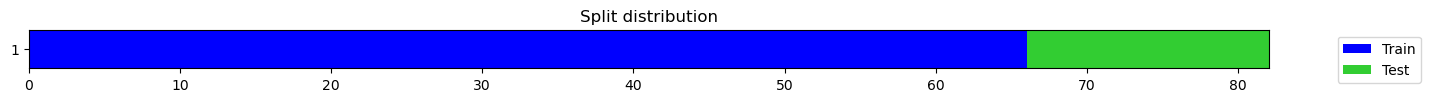

((#66) [0,1,2,3,4,5,6,7,8,9...], (#16) [66,67,68,69,70,71,72,73,74,75...])

In [ ]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
print(X.shape)
if config.analysis_mode == 'online':
    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
    
splits

## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [ ]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [ ]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

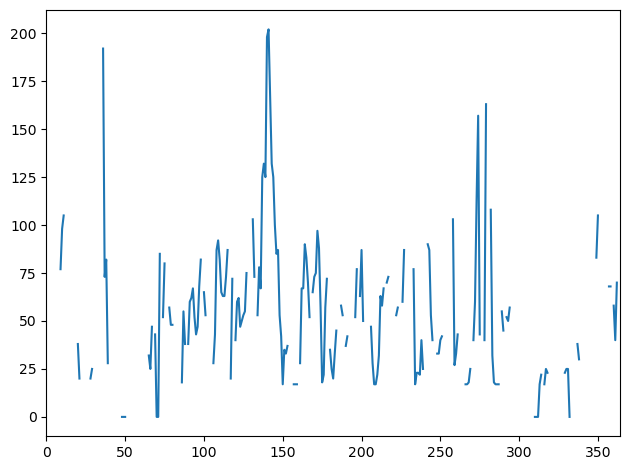

In [ ]:
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

### Build MVP TS Learner

In [ ]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                        window_size=config.mvp_ws, 
                        future_mask = config.mask_future, 
                        target_dir='./models', 
                        sync = config.mask_sync, 
                        stateful = config.mask_stateful,
                        fname=f'encoder_MVP'
                    ), y_range=[X.min(), X.max()])

### Example mask

#### Create mask

In [ ]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

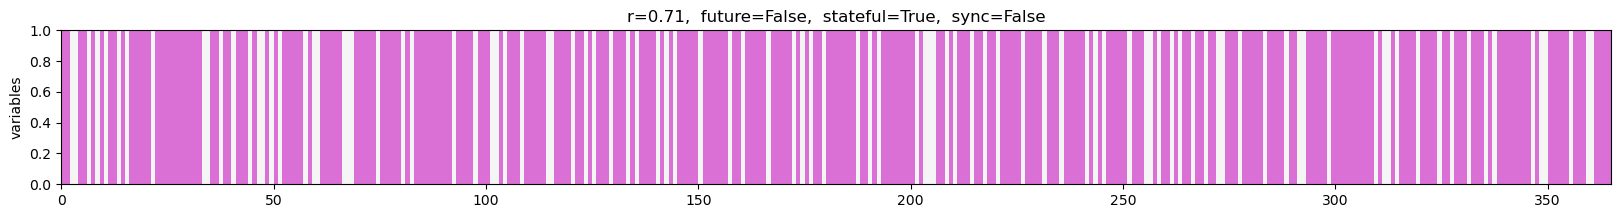

In [ ]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [ ]:
expected_window_size = config.mvp_ws
print("w", config.w, "mvp_ws", config.mvp_ws)
print("expected ", expected_window_size)


w 365 mvp_ws [7, 365]
expected  [7, 365]


### Check obtained attributes

In [ ]:
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size
print("obtained ", obtained_window_size)

obtained  [7, 365]


In [ ]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [ ]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    w_sizes = np.random.randint(obtained_window_size)
    print(w_sizes)

[  6 352]


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MMVP calculus

In [ ]:
#Get data batch
x = next(iter(dls.train))
print("x", x)
x_data=x[0]
print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
print("Time serie len: " + str( time_serie_len))
#Just in case
for ws in w_sizes:
    diff = time_serie_len - ws
    print("diff time serie len - ws", diff)
    result = np.random.randint(0, diff)
    print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:66, vars:1, len:365, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([66, 1, 365])
Time serie len: 365
diff time serie len - ws 359
ws  6 diff 359 result 335
diff time serie len - ws 13
ws  352 diff 13 result 11


### Train the model

epoch     train_loss  valid_loss  time     
0         1.572993    0.875897    00:00     


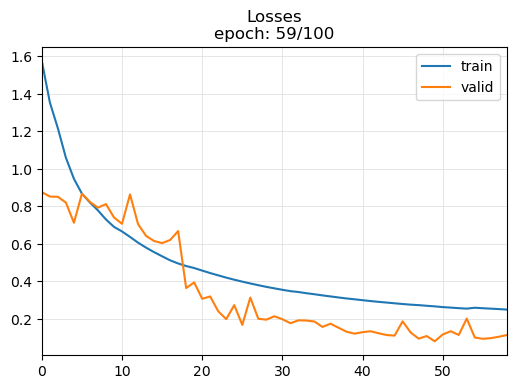

1         1.353781    0.852307    00:00     
2         1.215654    0.850919    00:00     
3         1.059089    0.820287    00:00     
4         0.947023    0.712688    00:00     
5         0.867534    0.867482    00:00     
6         0.820692    0.823881    00:00     
7         0.778324    0.793102    00:00     
8         0.730055    0.812172    00:00     
9         0.690771    0.740835    00:00     
10        0.666397    0.707288    00:00     
11        0.637252    0.863880    00:00     
12        0.606573    0.705425    00:00     
13        0.580144    0.642632    00:00     
14        0.556117    0.615439    00:00     
15        0.534066    0.604238    00:00     
16        0.512502    0.620825    00:00     
17        0.495856    0.668251    00:00     
18        0.482167    0.364942    00:00     
19        0.471441    0.394717    00:00     
20        0.457834    0.307763    00:00     
21        0.444668    0.320063    00:00     
22        0.432466    0.241222    00:00     
23        

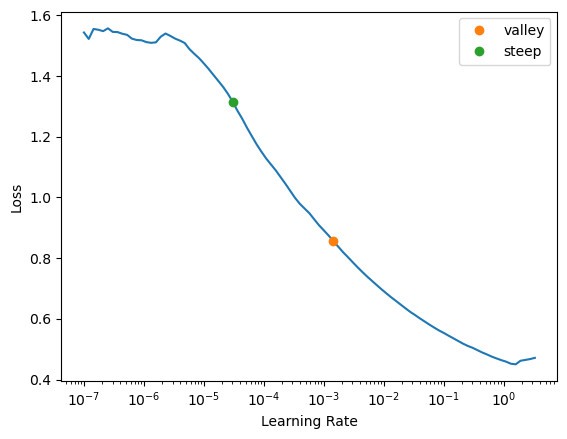

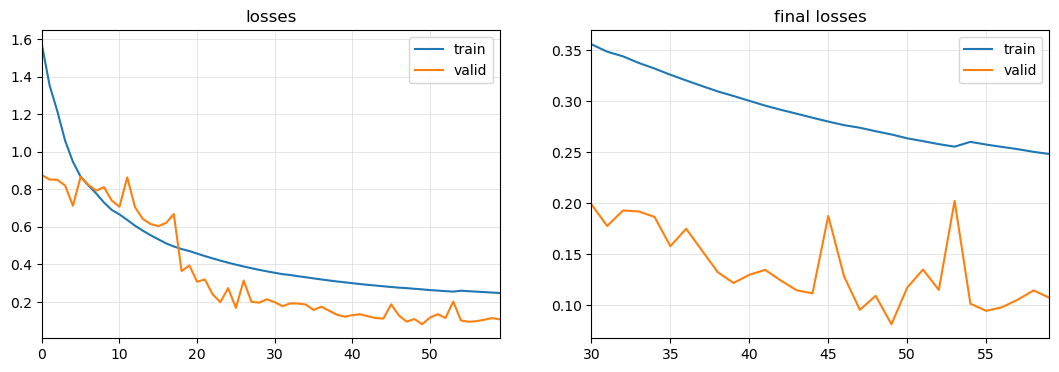

In [ ]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

#### Validate the model

In [ ]:
learn.validate()

not enough values to plot a chart


(#1) [0.4113345742225647]

## Visualize predictions

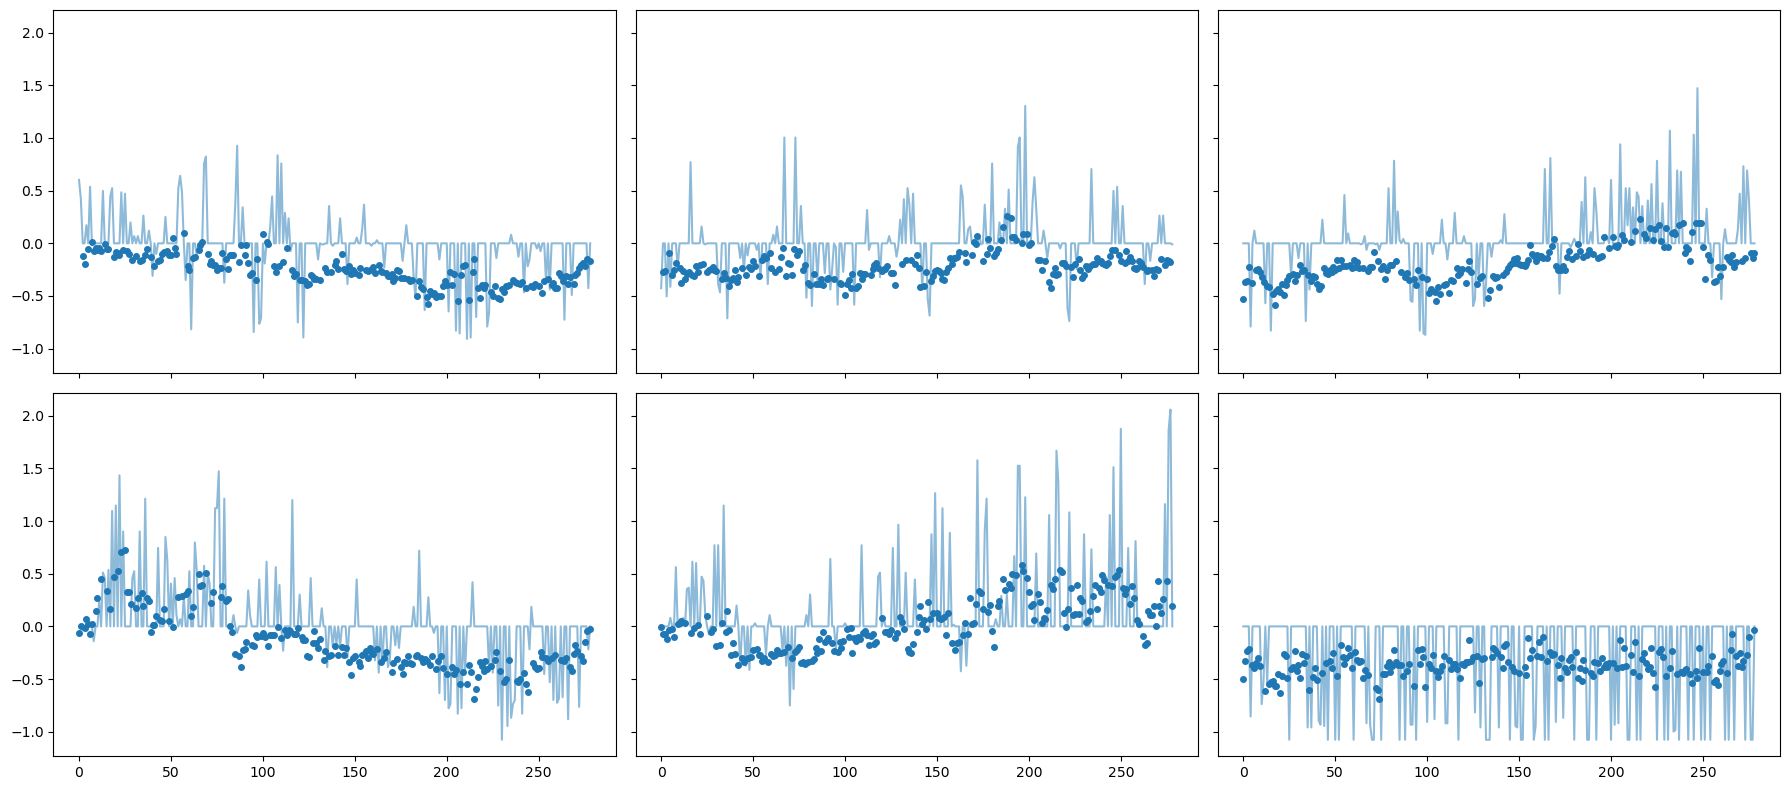

In [ ]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [ ]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

<fastai.learner.Learner>

In [ ]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [ ]:
run.finish()

epoch,60
eps_0,1e-05
eps_1,1e-05
lr_0,0.00083
lr_1,0.00083
mom_0,0.8927
mom_1,0.8927
raw_loss,0.17592
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.24808
